In [114]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import tensorflow as tf
import keras_tuner as kt

In [115]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [116]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [117]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [118]:
ticker='TSLA'

In [119]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [120]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [121]:
dates = pd.to_datetime(df['Date'])

In [122]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [123]:
df_for_training = df[cols].astype(float)

In [124]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [125]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [126]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [127]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [128]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [129]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [130]:
def build_model(hp):
    hp_units=hp.Int('units',min_value=2,max_value=240,step=2)
    model=Sequential()
    model.add(LSTM(hp_units,activation='relu',input_shape=(X.shape[1],X.shape[2]),return_sequences=False))
    model.add(Dense(y.shape[1]))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')

    return model

early_stop=EarlyStopping(monitor='val_loss',patience=20)

In [131]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner = kt.GridSearch(build_model,
                     objective='val_loss',
                     project_name='lstm_tuning',
                     )

Reloading Tuner from ./lstm_tuning/tuner0.json


In [132]:
tuner.search(X, y, epochs=1000, validation_split=0.2, callbacks=[stop_early])

In [133]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('units')}.
""")


The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 114.



In [134]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
def forecast_bias(y_true, y_pred):
    return 100 * (np.mean(y_pred) - np.mean(y_true)) / np.mean(y_true)

Epoch 1/1000
3/3 [==============================] - 1s 51ms/step - loss: 0.0712 - val_loss: 0.1748
Epoch 2/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0636 - val_loss: 0.1608
Epoch 3/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0566 - val_loss: 0.1473
Epoch 4/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0500 - val_loss: 0.1344
Epoch 5/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0439 - val_loss: 0.1223
Epoch 6/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0382 - val_loss: 0.1109
Epoch 7/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0330 - val_loss: 0.1003
Epoch 8/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0283 - val_loss: 0.0904
Epoch 9/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0241 - val_loss: 0.0813
Epoch 10/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0203 - val_loss: 0.0729
Epoch 11/

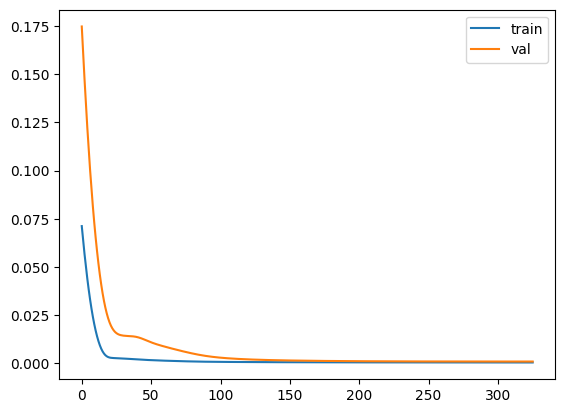

4/4 [==============================] - 0s 5ms/step
train mae: 0.681122808210795
val mae: 0.4379036602929688
train smape: 4.270689188785978
val smape: 2.511402689570992
train forecast bias: 1.5647603066034337
val forecast bias: 2.302711203476892


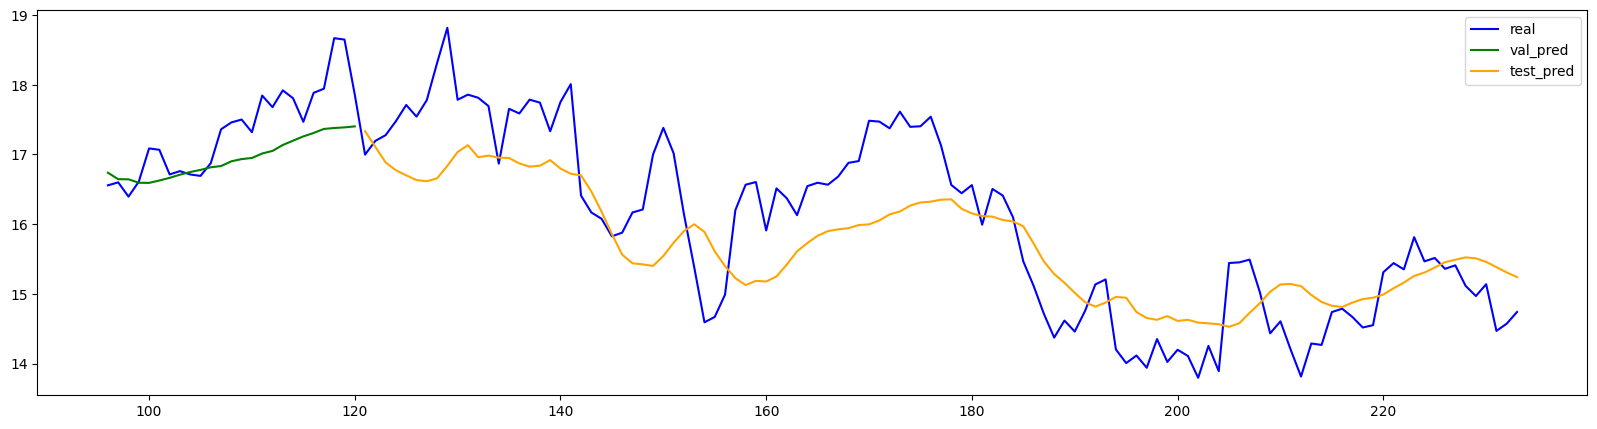

Epoch 1/1000
6/6 [==============================] - 1s 31ms/step - loss: 0.1198 - val_loss: 0.0747
Epoch 2/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.1020 - val_loss: 0.0609
Epoch 3/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.0858 - val_loss: 0.0484
Epoch 4/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.0712 - val_loss: 0.0374
Epoch 5/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.0581 - val_loss: 0.0279
Epoch 6/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.0464 - val_loss: 0.0199
Epoch 7/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.0362 - val_loss: 0.0134
Epoch 8/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.0274 - val_loss: 0.0083
Epoch 9/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.0201 - val_loss: 0.0046
Epoch 10/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.0143 - val_loss: 0.0022
Epoch 11/

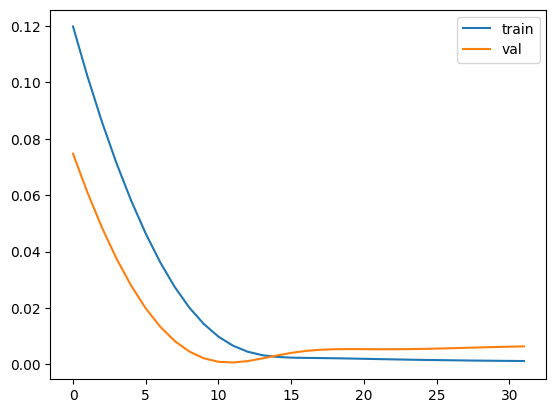

4/4 [==============================] - 0s 3ms/step
train mae: 2.032192275922117
val mae: 1.445884492396578
train smape: 13.97938303623134
val smape: 9.407417642863347
train forecast bias: -12.410601974272067
val forecast bias: -8.953221525557918


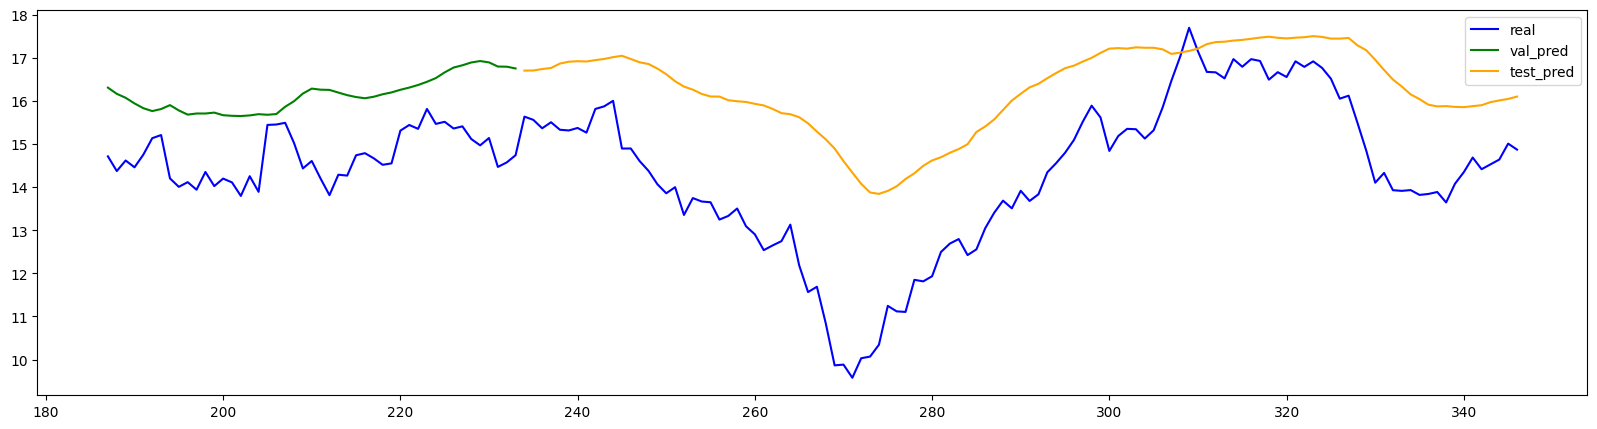

Epoch 1/1000
9/9 [==============================] - 1s 25ms/step - loss: 0.0499 - val_loss: 0.0536
Epoch 2/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0337 - val_loss: 0.0378
Epoch 3/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0222 - val_loss: 0.0263
Epoch 4/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0145 - val_loss: 0.0185
Epoch 5/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0100 - val_loss: 0.0136
Epoch 6/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0076 - val_loss: 0.0109
Epoch 7/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0064 - val_loss: 0.0094
Epoch 8/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0058 - val_loss: 0.0088
Epoch 9/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.0055 - val_loss: 0.0086
Epoch 10/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0052 - val_loss: 0.0087
Epoch 11/

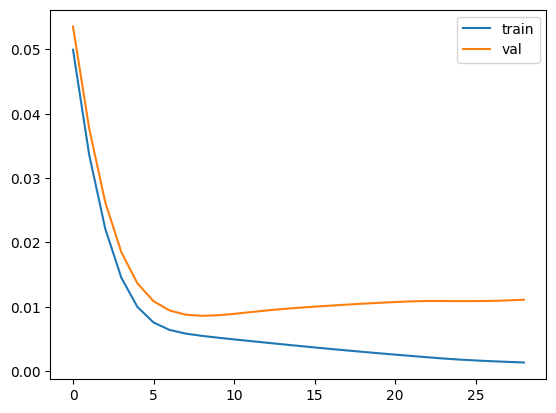

4/4 [==============================] - 0s 3ms/step
train mae: 1.6910582490061532
val mae: 1.7932123311131067
train smape: 12.559591577566371
val smape: 12.43094934595213
train forecast bias: 13.46812363144725
val forecast bias: 13.53445715979946


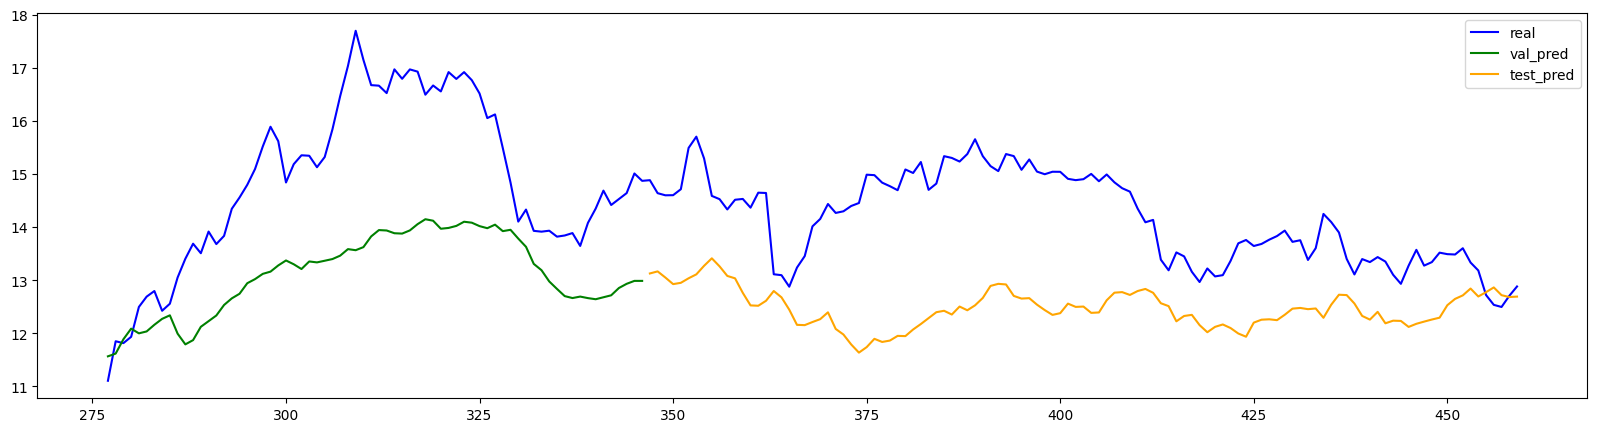

Epoch 1/1000
12/12 [==============================] - 1s 22ms/step - loss: 0.0801 - val_loss: 0.0566
Epoch 2/1000
12/12 [==============================] - 0s 15ms/step - loss: 0.0563 - val_loss: 0.0375
Epoch 3/1000
12/12 [==============================] - 0s 15ms/step - loss: 0.0378 - val_loss: 0.0226
Epoch 4/1000
12/12 [==============================] - 0s 14ms/step - loss: 0.0237 - val_loss: 0.0118
Epoch 5/1000
12/12 [==============================] - 0s 14ms/step - loss: 0.0139 - val_loss: 0.0050
Epoch 6/1000
12/12 [==============================] - 0s 14ms/step - loss: 0.0081 - val_loss: 0.0019
Epoch 7/1000
12/12 [==============================] - 0s 14ms/step - loss: 0.0054 - val_loss: 0.0011
Epoch 8/1000
12/12 [==============================] - 0s 14ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 9/1000
12/12 [==============================] - 0s 14ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 10/1000
12/12 [==============================] - 0s 14ms/step - loss: 0.0042 - val_lo

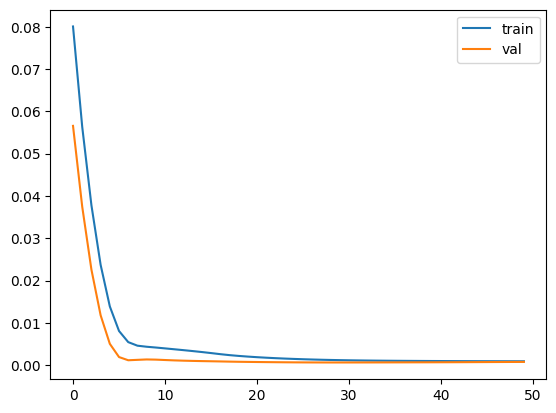

4/4 [==============================] - 0s 3ms/step
train mae: 1.3832854531071757
val mae: 0.43932542394157076
train smape: 8.999396356655417
val smape: 3.1279420169408825
train forecast bias: 9.400049968848812
val forecast bias: 1.9826570732600777


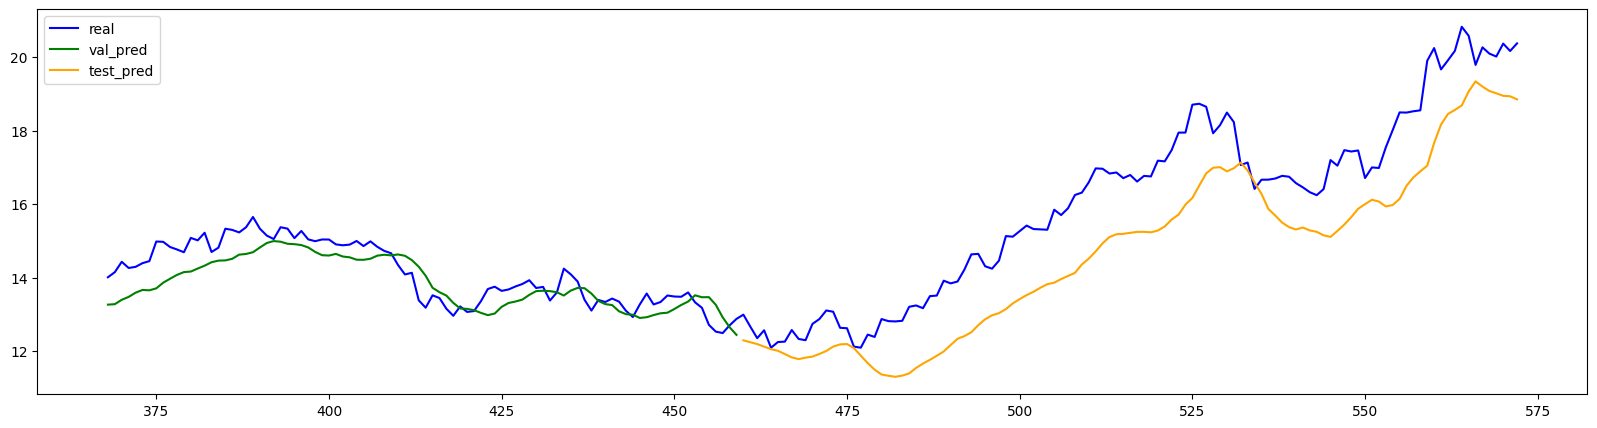

Epoch 1/1000
15/15 [==============================] - 1s 20ms/step - loss: 0.0558 - val_loss: 0.0746
Epoch 2/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0303 - val_loss: 0.0407
Epoch 3/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0158 - val_loss: 0.0230
Epoch 4/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0091 - val_loss: 0.0158
Epoch 5/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0067 - val_loss: 0.0133
Epoch 6/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0057 - val_loss: 0.0125
Epoch 7/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0052 - val_loss: 0.0123
Epoch 8/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0048 - val_loss: 0.0125
Epoch 9/1000
15/15 [==============================] - 0s 15ms/step - loss: 0.0044 - val_loss: 0.0128
Epoch 10/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0041 - val_lo

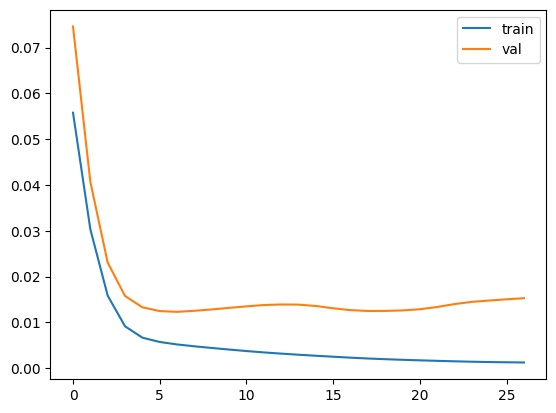

4/4 [==============================] - 0s 4ms/step
train mae: 5.758502373050116
val mae: 1.893095610688052
train smape: 28.828806337704982
val smape: 11.680118083560169
train forecast bias: 33.71542650692849
val forecast bias: 13.064239657800202


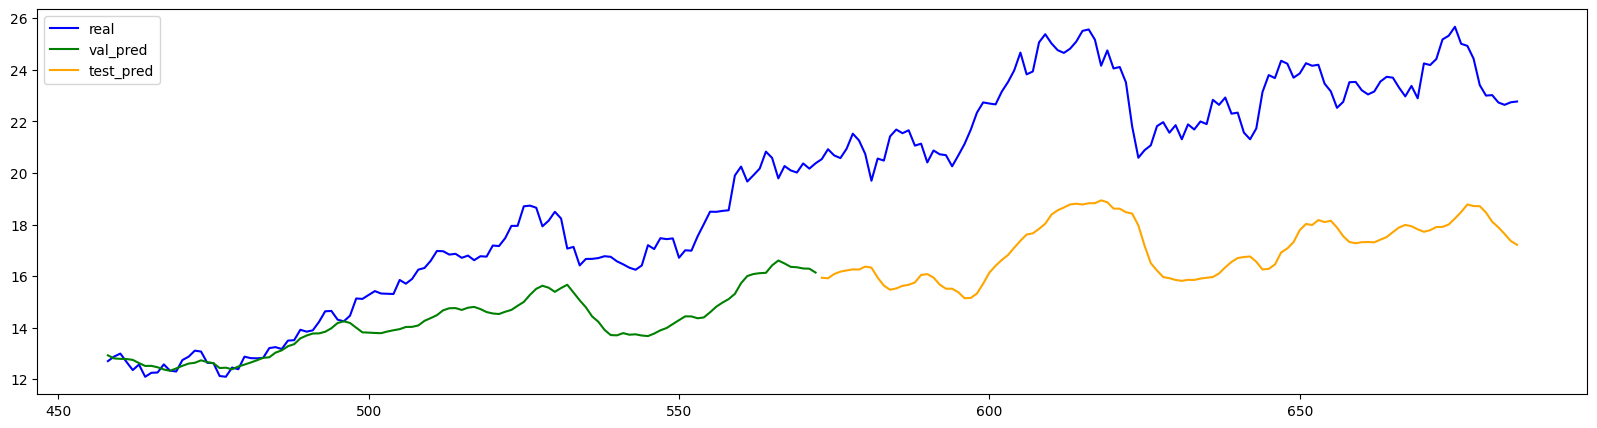

Epoch 1/1000
18/18 [==============================] - 1s 19ms/step - loss: 0.0918 - val_loss: 0.5266
Epoch 2/1000
18/18 [==============================] - 0s 15ms/step - loss: 0.0534 - val_loss: 0.3955
Epoch 3/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.0297 - val_loss: 0.2970
Epoch 4/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.0176 - val_loss: 0.2288
Epoch 5/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.0130 - val_loss: 0.1898
Epoch 6/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.0114 - val_loss: 0.1720
Epoch 7/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.0105 - val_loss: 0.1641
Epoch 8/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.0098 - val_loss: 0.1589
Epoch 9/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.0092 - val_loss: 0.1535
Epoch 10/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.0086 - val_lo

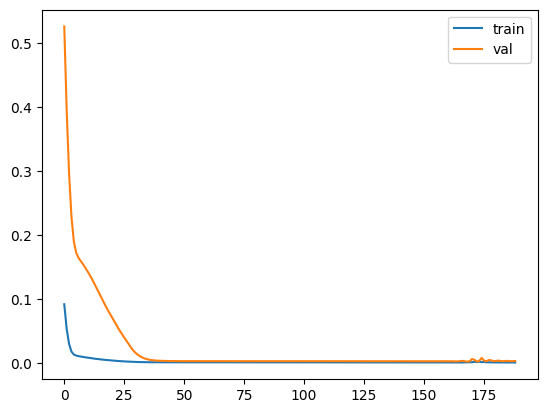

4/4 [==============================] - 0s 3ms/step
train mae: 0.6488761008732887
val mae: 0.8118228337871164
train smape: 2.9324244220864033
val smape: 3.6329854537848165
train forecast bias: 1.2936949942592935
val forecast bias: 2.7434614492589984


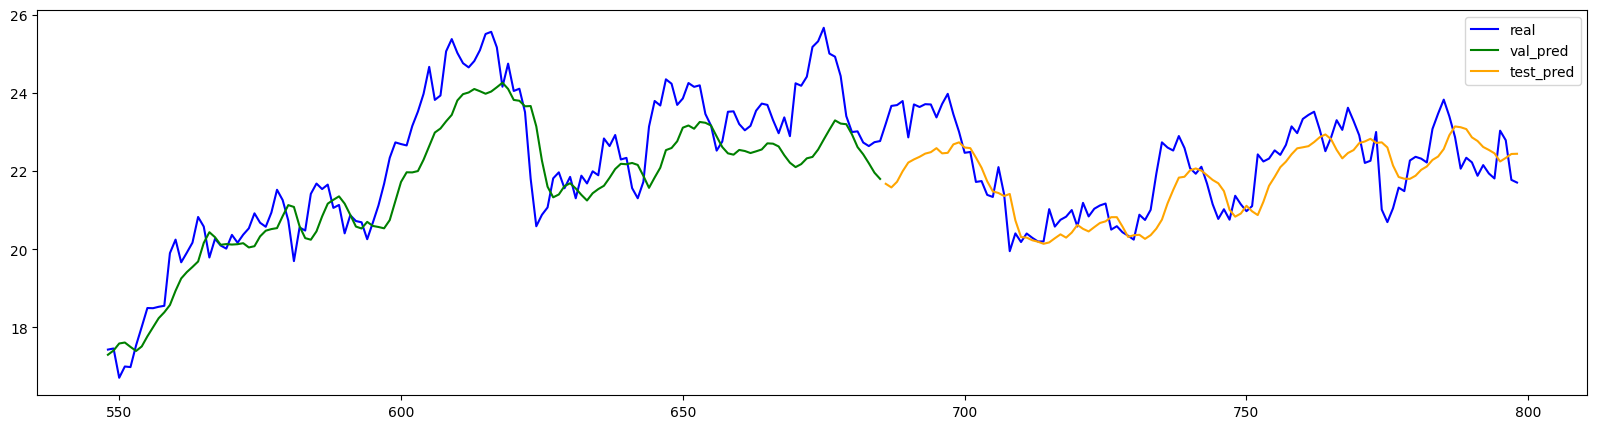

Epoch 1/1000
20/20 [==============================] - 1s 18ms/step - loss: 0.1202 - val_loss: 0.3494
Epoch 2/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.0643 - val_loss: 0.2121
Epoch 3/1000
20/20 [==============================] - 0s 16ms/step - loss: 0.0319 - val_loss: 0.1219
Epoch 4/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.0166 - val_loss: 0.0689
Epoch 5/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.0119 - val_loss: 0.0432
Epoch 6/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.0107 - val_loss: 0.0322
Epoch 7/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.0098 - val_loss: 0.0267
Epoch 8/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.0088 - val_loss: 0.0223
Epoch 9/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.0078 - val_loss: 0.0183
Epoch 10/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.0069 - val_lo

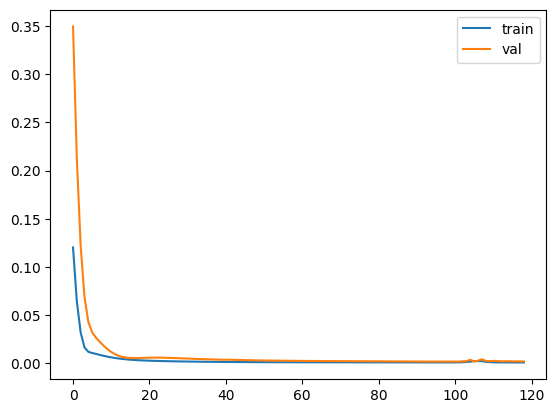

4/4 [==============================] - 0s 2ms/step
train mae: 1.1104125648355399
val mae: 0.6574524531692503
train smape: 5.327928147686334
val smape: 2.9098740532109346
train forecast bias: -2.8842722036383104
val forecast bias: -0.2379572108333058


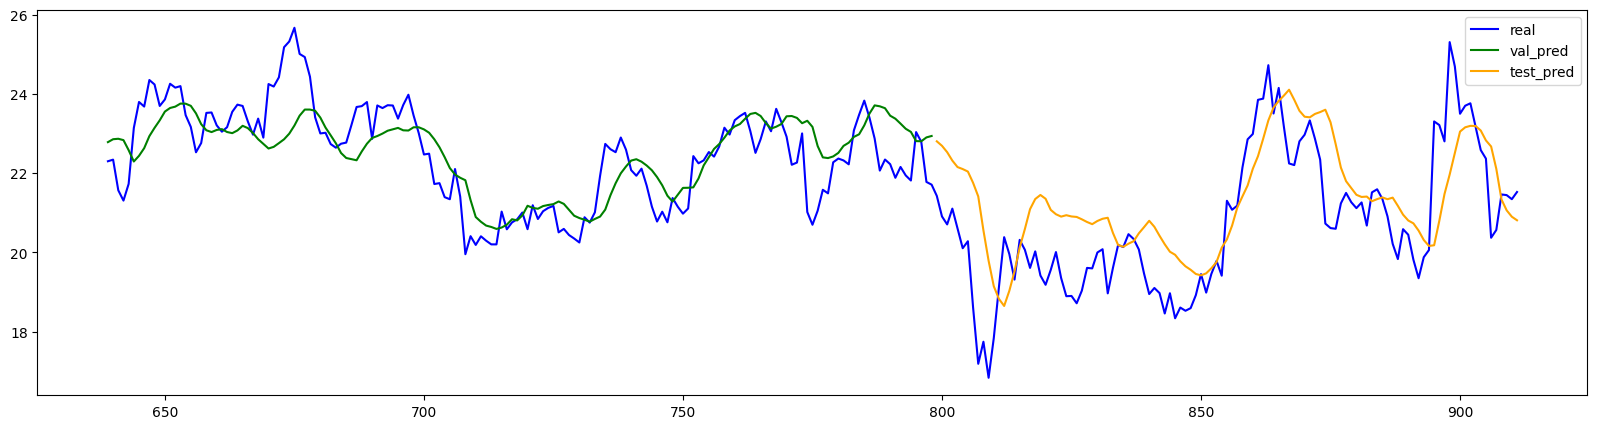

Epoch 1/1000
23/23 [==============================] - 1s 19ms/step - loss: 0.0683 - val_loss: 0.0810
Epoch 2/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0251 - val_loss: 0.0167
Epoch 3/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0111 - val_loss: 0.0065
Epoch 4/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0084 - val_loss: 0.0110
Epoch 5/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0071 - val_loss: 0.0137
Epoch 6/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0059 - val_loss: 0.0157
Epoch 7/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0050 - val_loss: 0.0183
Epoch 8/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0042 - val_loss: 0.0209
Epoch 9/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0037 - val_loss: 0.0230
Epoch 10/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0033 - val_lo

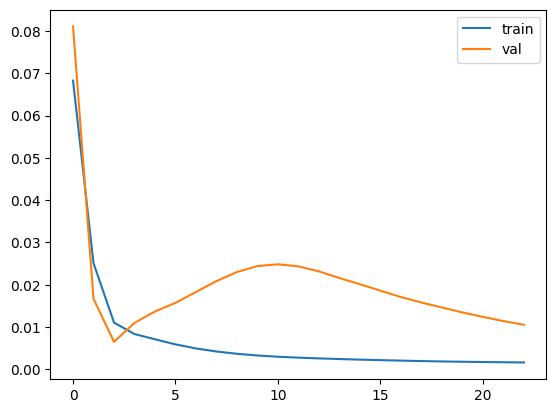

4/4 [==============================] - 0s 3ms/step
train mae: 2.2323816195478865
val mae: 1.7045278373856674
train smape: 10.279068961558217
val smape: 7.855614346583531
train forecast bias: -9.434307223406577
val forecast bias: -6.874536578134196


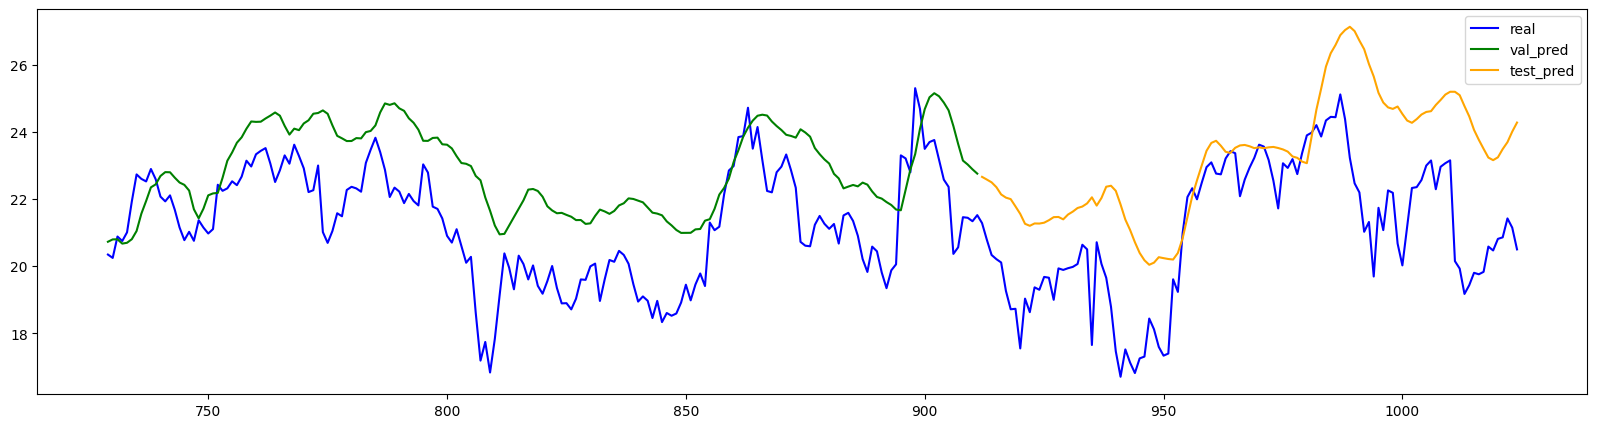

Epoch 1/1000
26/26 [==============================] - 1s 17ms/step - loss: 0.0609 - val_loss: 0.0158
Epoch 2/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0154 - val_loss: 0.0289
Epoch 3/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0106 - val_loss: 0.0414
Epoch 4/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0093 - val_loss: 0.0330
Epoch 5/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0084 - val_loss: 0.0294
Epoch 6/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0074 - val_loss: 0.0263
Epoch 7/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0065 - val_loss: 0.0228
Epoch 8/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0057 - val_loss: 0.0196
Epoch 9/1000
26/26 [==============================] - 0s 16ms/step - loss: 0.0049 - val_loss: 0.0165
Epoch 10/1000
26/26 [==============================] - 0s 15ms/step - loss: 0.0042 - val_lo

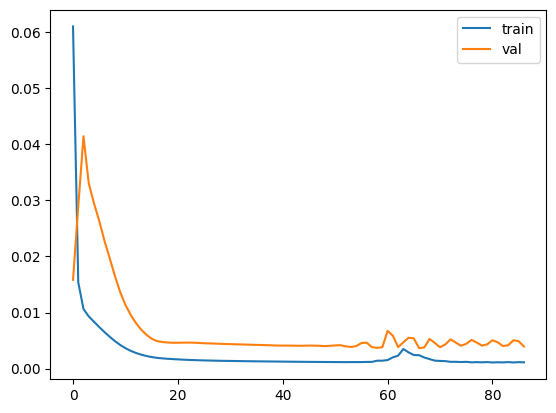

4/4 [==============================] - 0s 3ms/step
train mae: 1.7839874358952619
val mae: 0.9700459832829171
train smape: 10.748909969768874
val smape: 4.631974736223046
train forecast bias: -9.417975875419595
val forecast bias: 2.0469904732338895


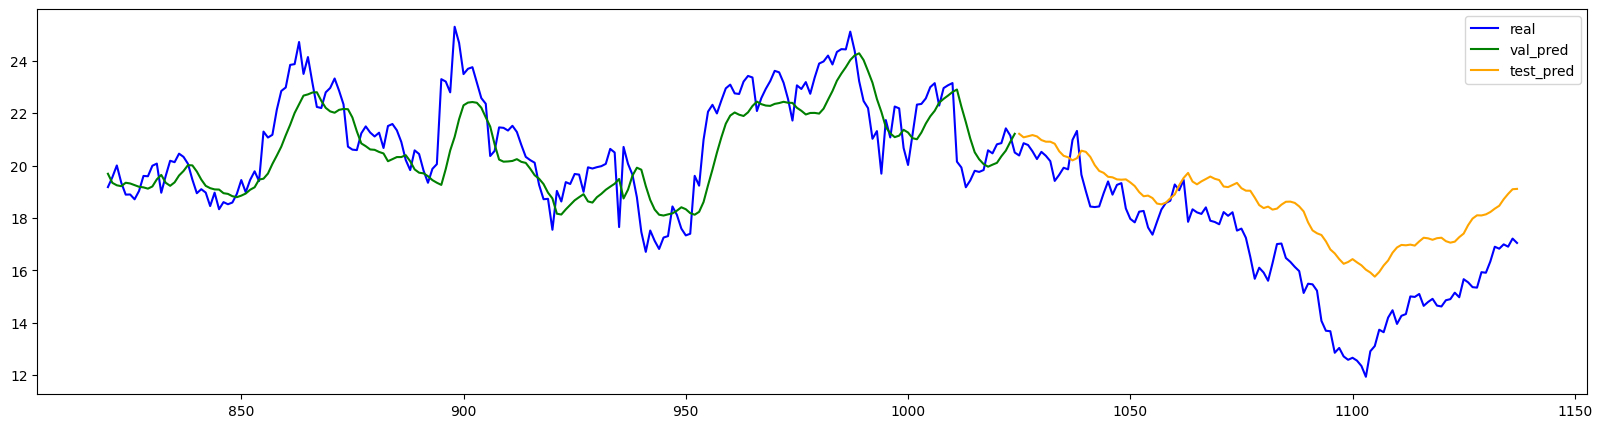

Epoch 1/1000
29/29 [==============================] - 1s 17ms/step - loss: 0.1888 - val_loss: 0.0842
Epoch 2/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0819 - val_loss: 0.0218
Epoch 3/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0328 - val_loss: 0.0430
Epoch 4/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0170 - val_loss: 0.0789
Epoch 5/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0134 - val_loss: 0.0812
Epoch 6/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0119 - val_loss: 0.0706
Epoch 7/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0106 - val_loss: 0.0589
Epoch 8/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0092 - val_loss: 0.0497
Epoch 9/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0082 - val_loss: 0.0428
Epoch 10/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0072 - val_lo

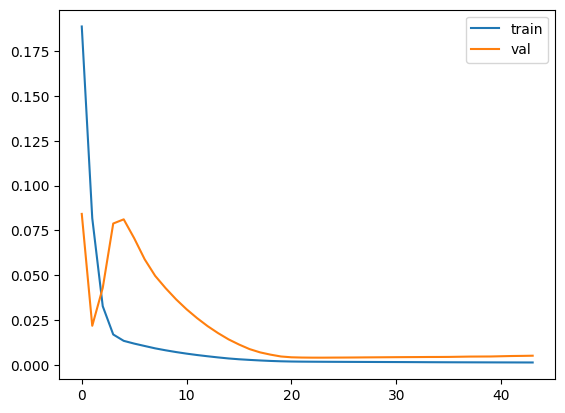

4/4 [==============================] - 0s 3ms/step
train mae: 1.088123757296132
val mae: 1.1150161805730452
train smape: 5.618817984722912
val smape: 6.056630392711288
train forecast bias: 0.9597708883012939
val forecast bias: -4.082796481597122


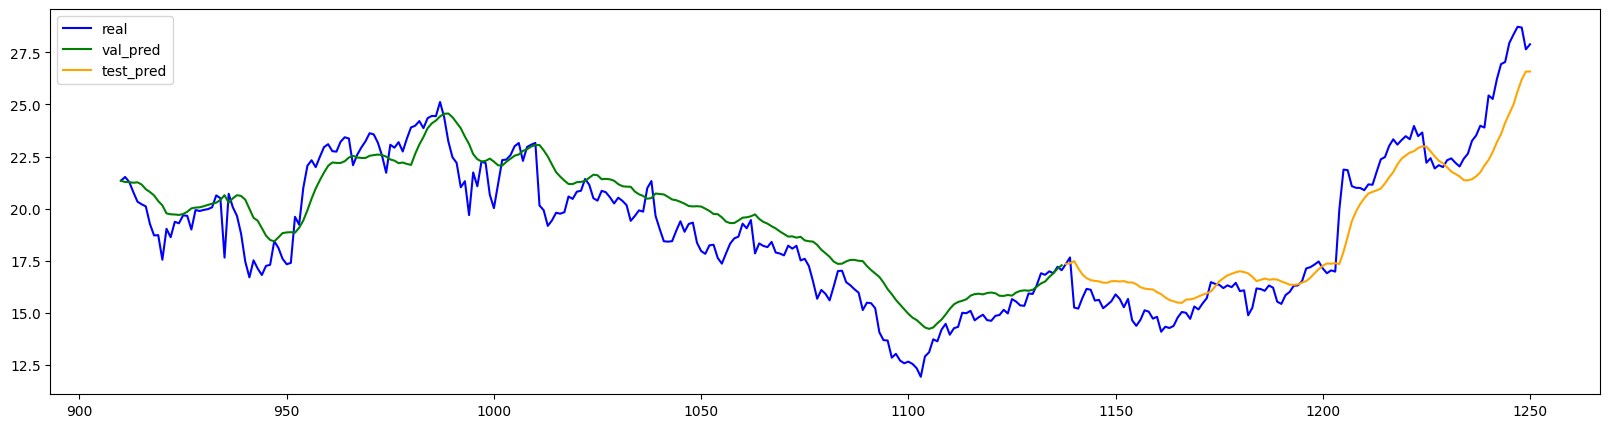

In [135]:
tscv = TimeSeriesSplit(n_splits=10)
t_maes=[]
v_maes=[]
t_smapes=[]
v_smapes=[]
t_forecast_biases=[]
v_forecast_biases=[]
for train_index, test_index in tscv.split(X):
    X_tmp, X_test = X[train_index], X[test_index]
    y_tmp, y_test= y[train_index], y[test_index]
    val_split = int(len(train_index) * 0.8)  # Adjust the validation split percentage as needed
    X_train, x_val = X_tmp[:val_split], X_tmp[val_split:]
    y_train, y_val = y_tmp[:val_split], y_tmp[val_split:]

    model=model = tuner.hypermodel.build(best_hps)
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    y_test=np.repeat(y_test,X.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 
    y_val=np.repeat(y_val,X.shape[2],axis=1)
    y_val=scaler.inverse_transform(y_val)[:,-1]

    y_val_pred=model.predict(x_val)
    val_pred=np.repeat(y_val_pred,X.shape[2],axis=1)
    val_pred=scaler.inverse_transform(val_pred)[:,-1]

    y_pred=model.predict(X_test)
    pred=np.repeat(y_pred,X_train.shape[2],axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]
    
    v_time=range(X_train.shape[0],X_train.shape[0]+len(y_val))

    t_time=range(X_train.shape[0]+len(y_val),X_train.shape[0]+len(y_val)+len(y_test))

    r_time=range(X_train.shape[0],X_train.shape[0]+len(y_val)+len(y_test))

    t_mae=mae(pred,y_test)
    t_maes.append(t_mae)
    print('train mae:',t_mae)
    v_mae=mae(val_pred,y_val)
    v_maes.append(v_mae)
    print('val mae:',v_mae)
    t_smape=smape(pred,y_test)
    t_smapes.append(t_smape)
    print('train smape:',t_smape)
    v_smape=smape(val_pred,y_val)
    v_smapes.append(v_smape)
    print('val smape:',v_smape)
    t_forecast_bias=forecast_bias(pred,y_test)
    t_forecast_biases.append(t_forecast_bias)
    print('train forecast bias:',t_forecast_bias)
    v_forecast_bias=forecast_bias(val_pred,y_val)
    v_forecast_biases.append(v_forecast_bias)
    print('val forecast bias:',v_forecast_bias)
    

    #plotting the results
    real=np.concatenate((y_val,y_test))
    plt.figure(figsize=(20,5))
    plt.plot(r_time,real,label='real',color='blue')
    plt.plot(v_time,val_pred,label='val_pred',color='green')
    plt.plot(t_time,pred, label='test_pred',color='orange') 
    plt.legend()
    plt.show()

In [136]:
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 114)               60192     
                                                                 
 dense_44 (Dense)            (None, 1)                 115       
                                                                 
Total params: 60307 (235.57 KB)
Trainable params: 60307 (235.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [137]:
Taverage_mae=np.mean(t_maes)

print('Average MAE in testing:',Taverage_mae)

Vaverage_mae=np.mean(v_maes)

print('Average MAE in validation:',Vaverage_mae)

Taverage_smape=np.mean(t_smapes)

print('Average SMAPE in testing:',Taverage_smape)

Vaverage_smape=np.mean(v_smapes)

print('Average SMAPE in validation:',Vaverage_smape)


Taverage_forecast_bias=np.mean(t_forecast_biases)

print('Average forecast bias in testing:',Taverage_forecast_bias)

Vaverage_forecast_bias=np.mean(v_forecast_biases)

print('Average forecast bias in validation:',Vaverage_forecast_bias)


Average MAE in testing: 1.8409942637744465
Average MAE in validation: 1.1268286806630274
Average SMAPE in testing: 10.354501598276682
Average SMAPE in validation: 6.424490876140114
Average forecast bias in testing: 2.625466901965202
Average forecast bias in validation: 1.5526005220706978
